In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, sws_replace, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets, get_layer_data
from retrain_layer import retrain_layer
retraining_epochs = 50


#test_data_full = Variable(test_data(fetch = "data")).cuda()
#test_labels_full = Variable(test_data(fetch = "labels")).cuda()
#val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
#val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()


/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [55]:
layer_model_1, gmp_1, res_1 = retrain_layer(5000, 2, 5000, 10, 15, 1, 1e-4, 3, "search", "LeNet_300_100", "MSEHNA", "./expfiles")

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131854.25
Epoch: 50. Loss: -133429.42
Original: 98.26% - Retrain: 98.24% - Prune: 98.05% - Quantize: 97.88% - Sparsity: 55.54%
Original: 98.15% - Retrain: 98.17% - Prune: 97.94% - Quantize: 97.77% - Sparsity: 55.54%


In [43]:
#1. Train all 3 layers
#2. Unify model and replace priors
#3. Optimize as usual
def layer_retrain_LeNet_300_100(mean, zmean, temp, tau, mixtures, data_size, loss_type = 'MSEHNA', savedir = ''):
    zvar = 10
    var = 2
    model_name = 'LeNet_300_100'
    
    #train 3 layers independently
    layer_model_1, gmp_1, res_1 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 1, data_size, model_name, loss_type, savedir)
    layer_model_2, gmp_2, res_2 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 2, data_size, model_name, loss_type, savedir)
    layer_model_3, gmp_3, res_3 = retrain_layer(mean, var, zmean, zvar, mixtures, temp, tau, 3, data_size, model_name, loss_type, savedir)

    #transfer GMP to new unified model architecture
    unified_model = sws_replace(model_archs.LeNet_300_100().cuda(), [layer_model_1.state_dict(), layer_model_2.state_dict(), layer_model_3.state_dict()])
    gmp_u1 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc1.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_1.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u2 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc2.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_2.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u3 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc3.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_3.means.clone().data.cpu().numpy(), scaling = False)

    #load datasets
    data_size = 'search'
    if(data_size == 'search'):
        train_dataset = search_train_data()
        val_data_full = Variable(test_data(fetch='data')).cuda()
        val_labels_full = Variable(test_data(fetch='labels')).cuda()
        un_val_acc = test_accuracy(val_data_full, val_labels_full, unified_model)[0]
    if(data_size == 'full'):
        train_dataset = train_data()

    loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    
    #unified accuracy
    unify_res = plot_data(unified_model, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    unify_res.data_epoch(0, unified_model)
    
    #prune-stats before retraining
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    unify_res.data_prune(pruned_model)
    preprune = copy.deepcopy(unify_res.prune_acc)
    presparsity = unify_res.sparsity
    
    
    #init optimizers
    loss_type = 'CESNT'
    opt_1 = torch.optim.Adam([
            {'params': unified_model.fc1.parameters(), 'lr': 1e-4},
            {'params': [gmp_u1.means], 'lr': 3e-4},
            {'params': [gmp_u1.gammas, gmp_u1.rhos], 'lr': 3e-3}])
    opt_2 = torch.optim.Adam([
            {'params': unified_model.fc2.parameters(), 'lr': 1e-4},
            {'params': [gmp_u2.means], 'lr': 3e-4},
            {'params': [gmp_u2.gammas, gmp_u2.rhos], 'lr': 3e-3}])
    opt_3 = torch.optim.Adam([
            {'params': unified_model.fc3.parameters(), 'lr': 1e-4},
            {'params': [gmp_u3.means], 'lr': 3e-4},
            {'params': [gmp_u3.gammas, gmp_u3.rhos], 'lr': 3e-3}])

    #align and retrain
    show_sws_weights(unified_model)
    retraining_epochs=30
    for epoch in range(retraining_epochs):
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u1, opt_1, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u2, opt_2, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u3, opt_3, loader, tau, 1, loss_type)
        #test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
        #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
        #model_n, means = clamp_weights (model_n, means)
        unify_res.data_epoch(epoch+1, unified_model)
        
        if (trueAfterN(epoch, 10)):
            print ("Epoch: {}, Test Acc: {:.2f}".format(epoch+1, unify_res.test_accuracy[-1]))
    show_sws_weights(unified_model)

    #prune model
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    
    unify_res.data_prune(pruned_model)
    
    ures = unify_res.gen_dict()
    cm = compressed_model(pruned_model.state_dict(), [gmp_u1, gmp_u2, gmp_u3])
    ures['cm'] = cm.get_cr_list()
    ures['pre-sp'] = presparsity
    ures['pre-prune_acc'] = preprune

    show_sws_weights(pruned_model)
        
    ###SAVE MODEL, GMP, Res
    if (savedir != ""):
        exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}".format(unified_model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), data_size)
        torch.save(unified_model, savedir + '/mnist_retrain_layer_umodel_{}.m'.format(exp_name))
        with open(savedir + '/mnist_retrain_layer_u1gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u1, f)
        with open(savedir + '/mnist_retrain_layer_u2gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u2, f)
        with open(savedir + '/mnist_retrain_layer_u3gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u3, f)
        with open(savedir + '/mnist_retrain_layer_ures_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(ures, f)
    
    return layer_model_1, gmp_1, res_1, layer_model_2, gmp_2, res_2, layer_model_3, gmp_3, res_3, unified_model, ures

In [5]:
def loadfile(mean, zmean, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res"):
    r = 30 if file == 'ures' else 50
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}".format(model, mean, zmean, r, tau, int(mixtures), int(temp),data_size) + fn
    if (file=='res' or file == 'ures' or file == 'gmp'):
        with open(model_save_dir + '/mnist_retrain_layer_{}_{}.p'.format(file, exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/mnist_retrain_layer_model_{}.m'.format(exp_name))
    return file



In [7]:
gmp_1 = loadfile(mean = 5000, zmean = 5000, tau = 1e-6, temp = 1, mixtures = 15, model = "LeNet_300_100FC1", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")

In [45]:
#1. Train all 3 layers
#2. Unify model and replace priors
#3. Optimize as usual
def load_layer_retrain_LeNet_300_100(mean, zmean, temp, tau, mixtures, data_size, loss_type = 'MSEHNA', savedir = ''):
    zvar = 10
    var = 2
    model_name = 'LeNet_300_100'
    
    #train 3 layers independently
    #layer_model_1, gmp_1, res_1 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 1, data_size, model_name, loss_type, savedir)
    #layer_model_2, gmp_2, res_2 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 2, data_size, model_name, loss_type, savedir)
    #layer_model_3, gmp_3, res_3 = retrain_layer(mean, var, zmean, zvar, mixtures, temp, tau, 3, data_size, model_name, loss_type, savedir)
    layer_model_1 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = 1, mixtures = 15, model = "LeNet_300_100FC1", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    layer_model_2 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = 1, mixtures = 15, model = "LeNet_300_100FC2", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    layer_model_3 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = temp, mixtures = 15, model = "LeNet_300_100FC3", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    gmp_1 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = 1, mixtures = 15, model = "LeNet_300_100FC1", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    gmp_2 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = 1, mixtures = 15, model = "LeNet_300_100FC2", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    gmp_3 = loadfile(mean = 5000, zmean = 5000, tau = tau, temp = temp, mixtures = 15, model = "LeNet_300_100FC3", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    
    #transfer GMP to new unified model architecture
    unified_model = sws_replace(model_archs.LeNet_300_100().cuda(), [layer_model_1.state_dict(), layer_model_2.state_dict(), layer_model_3.state_dict()])
    gmp_u1 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc1.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_1.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u2 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc2.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_2.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u3 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc3.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_3.means.clone().data.cpu().numpy(), scaling = False)

    #load datasets
    data_size = 'search'
    if(data_size == 'search'):
        train_dataset = search_train_data()
        val_data_full = Variable(test_data(fetch='data')).cuda()
        val_labels_full = Variable(test_data(fetch='labels')).cuda()
        un_val_acc = test_accuracy(val_data_full, val_labels_full, unified_model)[0]
    if(data_size == 'full'):
        train_dataset = train_data()

    loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    
    
    #unified accuracy
    unify_res = plot_data(unified_model, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    unify_res.data_epoch(0, unified_model)
    
    #prune-stats before retraining
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    unify_res.data_prune(pruned_model)
    preprune = copy.deepcopy(unify_res.prune_acc)
    presparsity = unify_res.sparsity
    
    #init optimizers
    loss_type = 'CESNT'
    opt_1 = torch.optim.Adam([
            {'params': unified_model.fc1.parameters(), 'lr': 1e-4},
            {'params': [gmp_u1.means], 'lr': 3e-4},
            {'params': [gmp_u1.gammas, gmp_u1.rhos], 'lr': 3e-3}])
    opt_2 = torch.optim.Adam([
            {'params': unified_model.fc2.parameters(), 'lr': 1e-4},
            {'params': [gmp_u2.means], 'lr': 3e-4},
            {'params': [gmp_u2.gammas, gmp_u2.rhos], 'lr': 3e-3}])
    opt_3 = torch.optim.Adam([
            {'params': unified_model.fc3.parameters(), 'lr': 1e-4},
            {'params': [gmp_u3.means], 'lr': 3e-4},
            {'params': [gmp_u3.gammas, gmp_u3.rhos], 'lr': 3e-3}])

    #align and retrain
    show_sws_weights(unified_model)
    retraining_epochs=30
    for epoch in range(retraining_epochs):
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u1, opt_1, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u2, opt_2, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u3, opt_3, loader, tau, 1, loss_type)
        #test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
        #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
        #model_n, means = clamp_weights (model_n, means)
        unify_res.data_epoch(epoch+1, unified_model)
        
        if (trueAfterN(epoch, 10)):
            print ("Epoch: {}, Test Acc: {:.2f}".format(epoch+1, unify_res.test_accuracy[-1]))
    show_sws_weights(unified_model)

    #prune model
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    show_sws_weights(pruned_model)
    unify_res.data_prune(pruned_model)
    
    ures = unify_res.gen_dict()
    cm = compressed_model(pruned_model.state_dict(), [gmp_u1, gmp_u2, gmp_u3])
    ures['cm'] = cm.get_cr_list()
    ures['pre-sp'] = presparsity
    ures['pre-prune_acc'] = preprune

    show_sws_weights(pruned_model)
        
    ###SAVE MODEL, GMP, Res
    if (savedir != ""):
        exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}".format(unified_model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), data_size)
        torch.save(unified_model, savedir + '/mnist_retrain_layer_umodel_{}.m'.format(exp_name))
        with open(savedir + '/mnist_retrain_layer_u1gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u1, f)
        with open(savedir + '/mnist_retrain_layer_u2gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u2, f)
        with open(savedir + '/mnist_retrain_layer_u3gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u3, f)
        with open(savedir + '/mnist_retrain_layer_ures_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(ures, f)
    
    return layer_model_1, gmp_1, layer_model_2, gmp_2, layer_model_3, gmp_3, unified_model, ures

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0


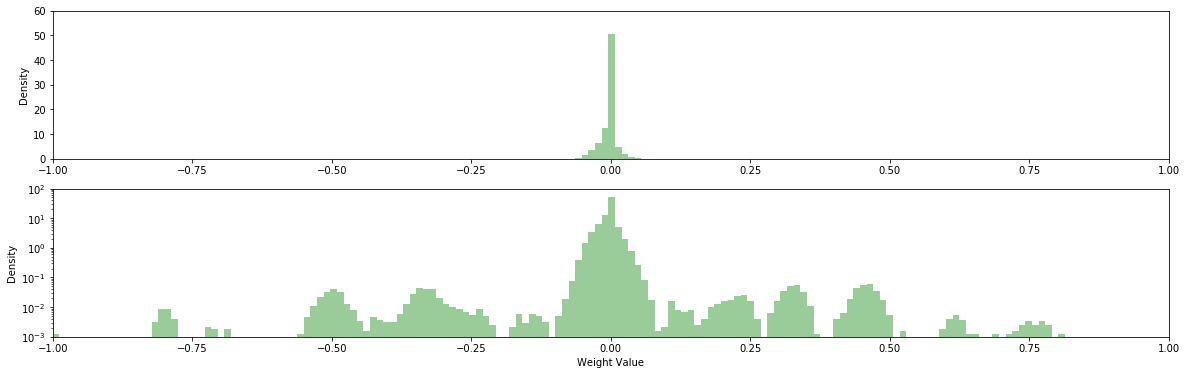

Layer Loss: 112186.539
Layer Loss: 176.292
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 17850.443
Layer Loss: 46.223
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.783
Layer Loss: 4.625
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 95.34
Epoch: 20, Test Acc: 95.66
Epoch: 30, Test Acc: 95.88


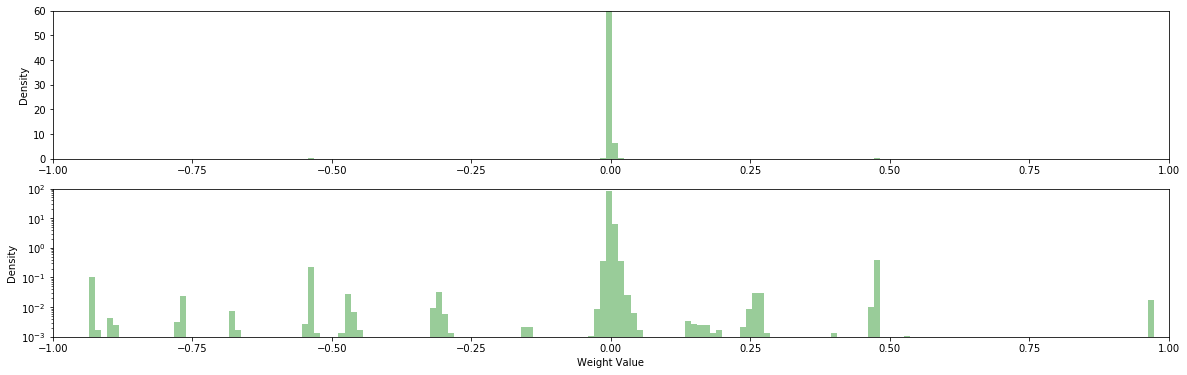

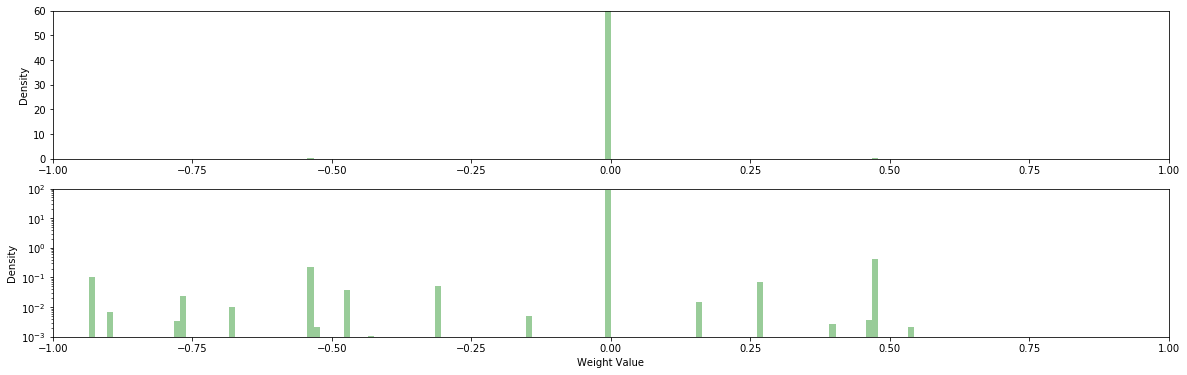

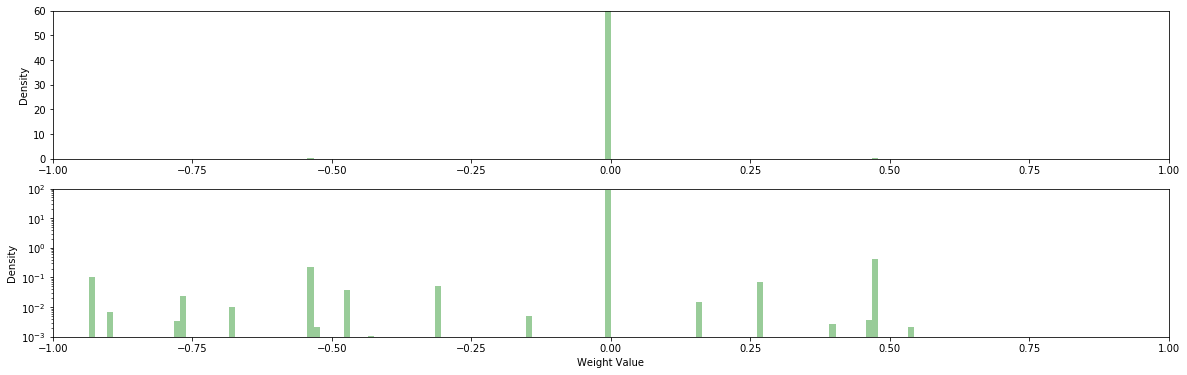

In [46]:
l1_4, g1_4, l2_4, g2_4, l3_4, g3_4, um_4, ur_4 = load_layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-5, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131901.09
Epoch: 50. Loss: -133479.30
Original: 98.26% - Retrain: 23.78% - Prune: 9.73% - Quantize: 9.74% - Sparsity: 99.90%
Original: 98.15% - Retrain: 24.34% - Prune: 10.10% - Quantize: 10.09% - Sparsity: 99.90%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131852.33
Epoch: 50. Loss: -133428.94
Original: 98.26% - Retrain: 95.22% - Prune: 91.24% - Quantize: 90.59% - Sparsity: 98.37%
Original: 98.15% - Retrain: 95.34% - Prune: 91.45% - Quantize: 91.04% - Sparsity: 98.37%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131854.20
Epoch: 50. Loss: -133429.42
Original: 98.26% - Retrain: 98.24% - Prune: 98.05% - Quantize: 97.84% - Sparsity: 55.74%
Original: 98.15% - Retrain: 98.16% - Prune: 97.94% - Quantize: 97.72% - Sparsity: 55.74%
0-component Mean: 5000.0 Variance: 10.0
No

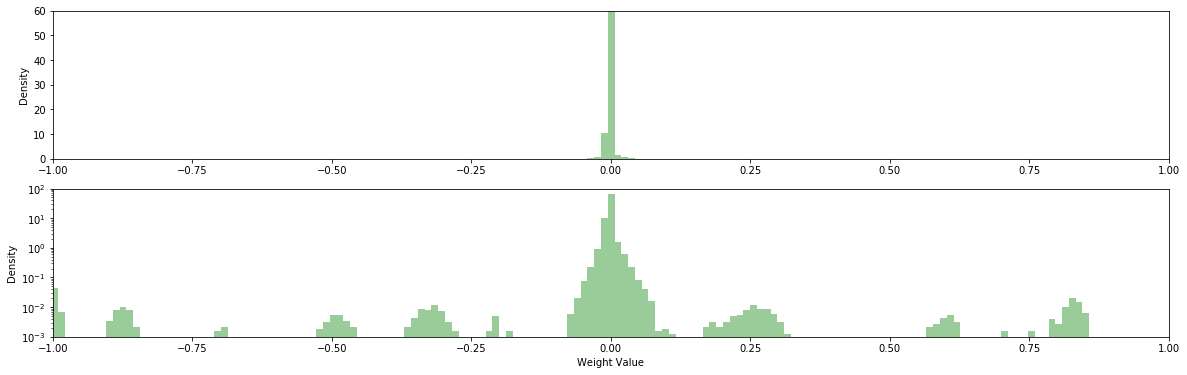

Layer Loss: 110094.250
Layer Loss: 152.700
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 16346.329
Layer Loss: 46.184
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 876.031
Layer Loss: 4.617
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 87.50
Epoch: 20, Test Acc: 90.79
Epoch: 30, Test Acc: 92.46


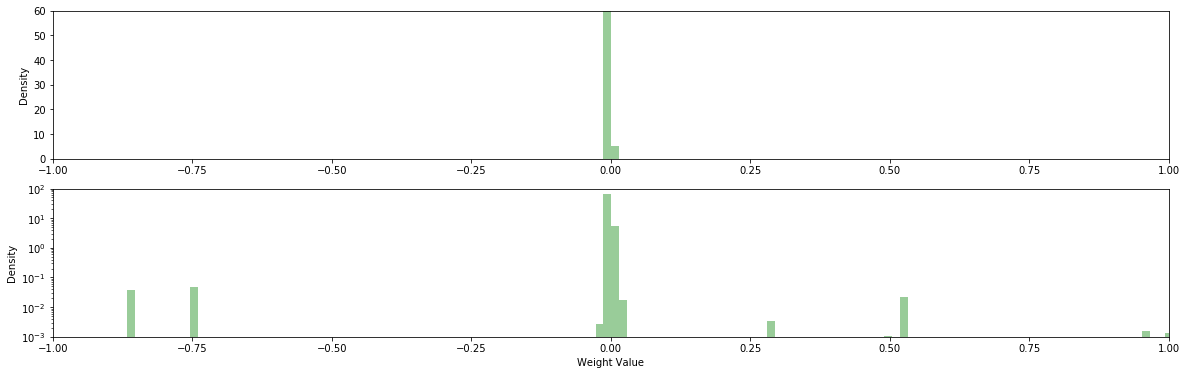

[ 0.         -0.77803123 -0.77645731 -0.74805111 -0.71831489 -0.38744515
 -0.01341826 -0.00395329  0.00634344  0.65606999  0.65820557  1.65098941
  1.00574994  0.66029459  1.65647066]
[ 0  0  0 ...  0 11  0]
[ 0.         -1.10356259 -0.84947371 -0.89181513 -0.92346638 -0.69366205
 -0.81823635  1.25378072  0.2926257   0.55356342  0.55752826  0.28497612
  1.55989432  1.04787111  0.49087894]
[0 0 0 ... 0 0 0]
[ 0.         -0.97844529 -0.97842854 -1.14451182 -0.4905223  -0.82653832
 -0.85701078 -0.33038551  0.52310795  0.95335972  1.39587522  1.39732087
  1.56527734  1.39733338  1.39723587]
[0 6 0 ... 0 0 0]


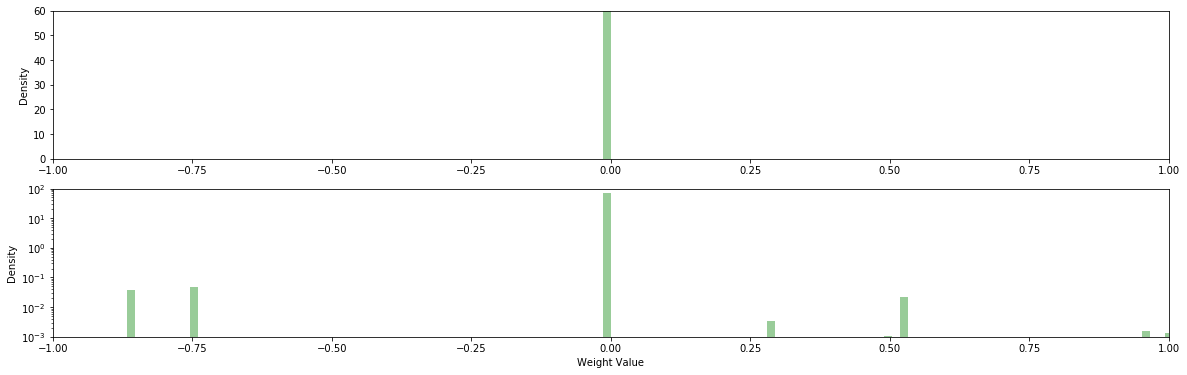

In [4]:
l1_4, g1_4, r1_4, l2_4, g2_4, r2_4, l3_4, g3_4, r3_4, um_4, ur_4 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-4, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -13187.63
Epoch: 50. Loss: -13344.95
Original: 98.26% - Retrain: 79.55% - Prune: 15.26% - Quantize: 15.20% - Sparsity: 99.81%
Original: 98.15% - Retrain: 80.25% - Prune: 14.69% - Quantize: 14.56% - Sparsity: 99.81%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -13184.67
Epoch: 50. Loss: -13342.51
Original: 98.26% - Retrain: 98.14% - Prune: 97.96% - Quantize: 97.81% - Sparsity: 90.08%
Original: 98.15% - Retrain: 97.99% - Prune: 97.96% - Quantize: 97.96% - Sparsity: 90.08%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -13185.41
Epoch: 50. Loss: -13342.92
Original: 98.26% - Retrain: 98.24% - Prune: 98.22% - Quantize: 98.19% - Sparsity: 32.97%
Original: 98.15% - Retrain: 98.17% - Prune: 98.16% - Quantize: 98.18% - Sparsity: 32.97%
0-component Mean: 5000.0 Variance: 10.0
Non-ze

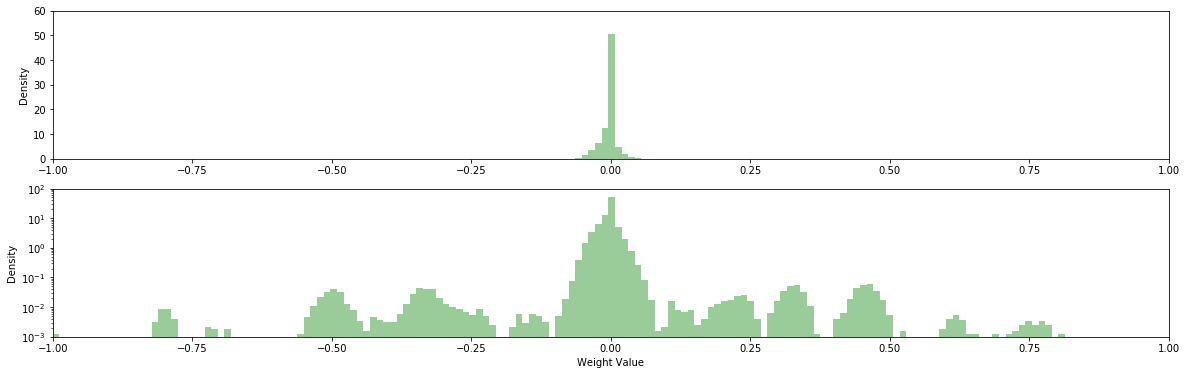

Layer Loss: 112186.539
Layer Loss: 176.292
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 17850.443
Layer Loss: 46.223
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.783
Layer Loss: 4.625
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 95.31
Epoch: 20, Test Acc: 95.64
Epoch: 30, Test Acc: 95.78


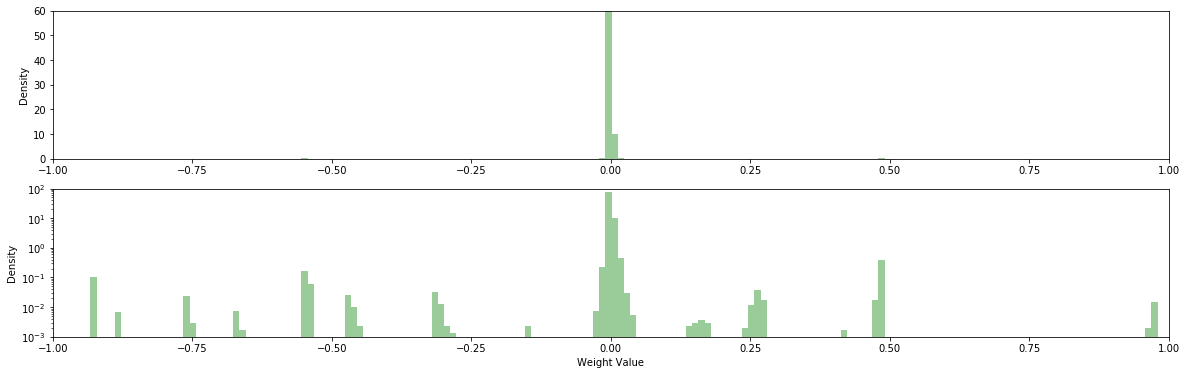

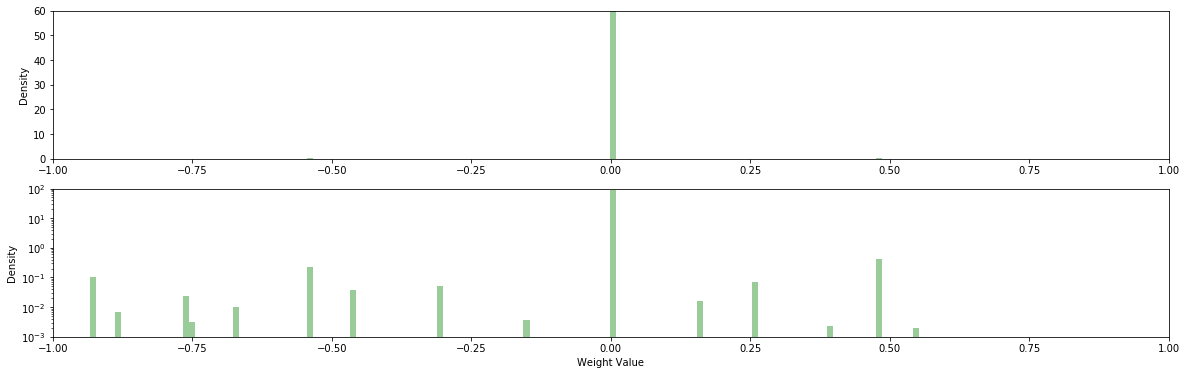

In [44]:
l1_5, g1_5, r1_5, l2_5, g2_5, r2_5, l3_5, g3_5, r3_5, um_5, ur_5 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-5, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

In [36]:
r1_5['prune_acc']

{'test': 98.26, 'train': 100.0, 'val': 98.15}

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -1318.28
Epoch: 50. Loss: -1334.03
Original: 98.26% - Retrain: 97.93% - Prune: 91.19% - Quantize: 90.13% - Sparsity: 85.71%
Original: 98.15% - Retrain: 97.81% - Prune: 92.24% - Quantize: 90.66% - Sparsity: 85.71%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -1318.39
Epoch: 50. Loss: -1334.16
Original: 98.26% - Retrain: 98.25% - Prune: 98.22% - Quantize: 98.17% - Sparsity: 72.03%
Original: 98.15% - Retrain: 98.18% - Prune: 98.21% - Quantize: 98.21% - Sparsity: 72.03%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -1318.54
Epoch: 50. Loss: -1334.29
Original: 98.26% - Retrain: 98.26% - Prune: 98.18% - Quantize: 98.05% - Sparsity: 22.97%
Original: 98.15% - Retrain: 98.15% - Prune: 98.13% - Quantize: 98.16% - Sparsity: 22.97%
0-component Mean: 5000.0 Variance: 10.0
Non-zero com

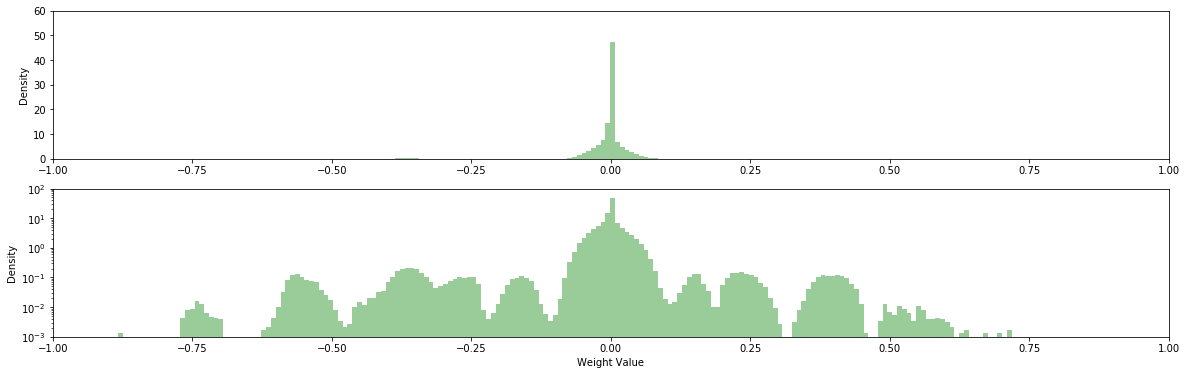

Layer Loss: 120485.484
Layer Loss: 150.656
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 18163.660
Layer Loss: 49.977
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.647
Layer Loss: 5.298
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 97.87
Epoch: 20, Test Acc: 97.79
Epoch: 30, Test Acc: 97.80


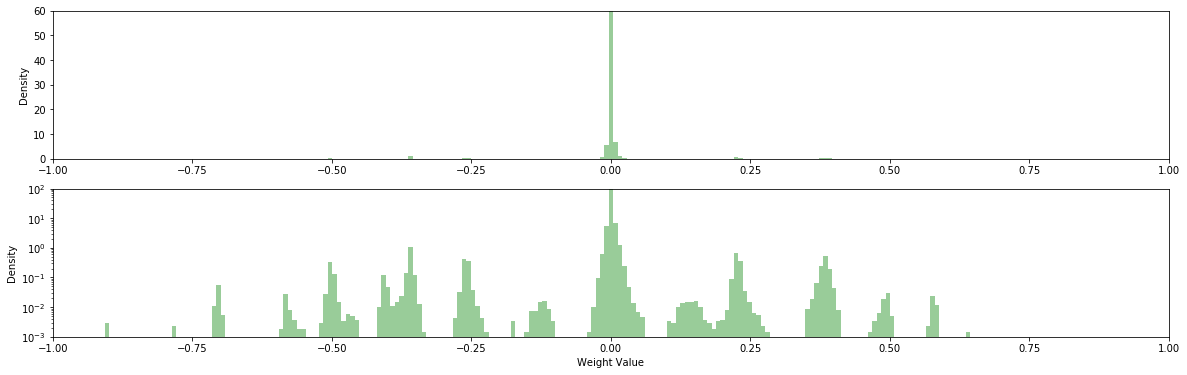

[ 0.         -0.3595297  -0.90542334 -0.71098965 -0.70361006 -0.17459908
 -0.50036764 -0.17423001 -0.00654652  0.31967115  0.38493106  0.38767344
  0.38437027  0.491521    0.64216554]
[ 0  0  0 ...  0 13  0]
[ 0.         -0.40496379 -0.58138597 -0.39705053 -0.78171366 -0.2592991
 -0.11861476 -0.11690007  0.1311639   0.11653732  0.37935972  0.57861102
  0.37392426  0.39546534  0.22657534]
[ 0  0  0 ... 14  0  0]
[ 0.         -0.3802346  -0.56491083 -0.27991086 -0.6888116  -0.25493246
 -0.46375862 -0.13251497  0.24418816  0.14207584  0.65326464  0.65326738
  0.66696745  0.69499624  0.6774798 ]
[8 6 5 ... 0 8 0]


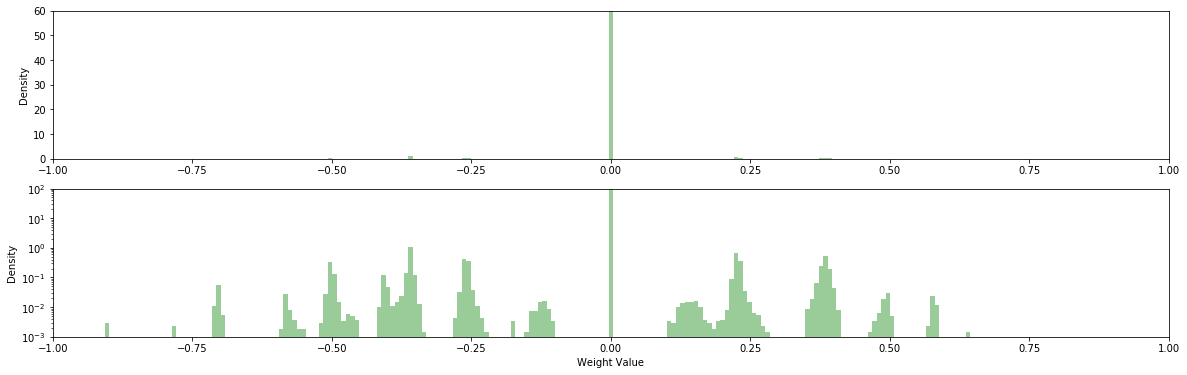

In [6]:
l1_6, g1_6, r1_6, l2_6, g2_6, r2_6, l3_6, g3_6, r3_6, um_6, ur_6 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-6, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131.78
Epoch: 50. Loss: -133.39
Original: 98.26% - Retrain: 98.33% - Prune: 97.61% - Quantize: 97.62% - Sparsity: 88.74%
Original: 98.15% - Retrain: 98.22% - Prune: 97.73% - Quantize: 97.78% - Sparsity: 88.74%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131.84
Epoch: 50. Loss: -133.41
Original: 98.26% - Retrain: 98.25% - Prune: 98.24% - Quantize: 98.23% - Sparsity: 44.46%
Original: 98.15% - Retrain: 98.11% - Prune: 98.15% - Quantize: 98.19% - Sparsity: 44.46%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Epoch: 25. Loss: -131.85
Epoch: 50. Loss: -133.43
Original: 98.26% - Retrain: 98.26% - Prune: 98.24% - Quantize: 98.12% - Sparsity: 21.68%
Original: 98.15% - Retrain: 98.15% - Prune: 98.19% - Quantize: 98.20% - Sparsity: 21.68%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component

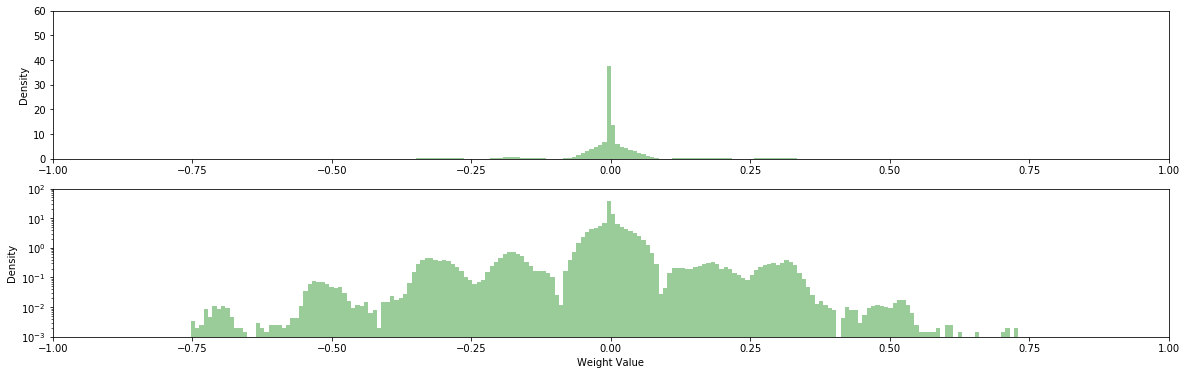

Layer Loss: 126271.117
Layer Loss: 154.439
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 18388.141
Layer Loss: 54.811
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.716
Layer Loss: 5.378
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 98.20
Epoch: 20, Test Acc: 98.14
Epoch: 30, Test Acc: 98.13


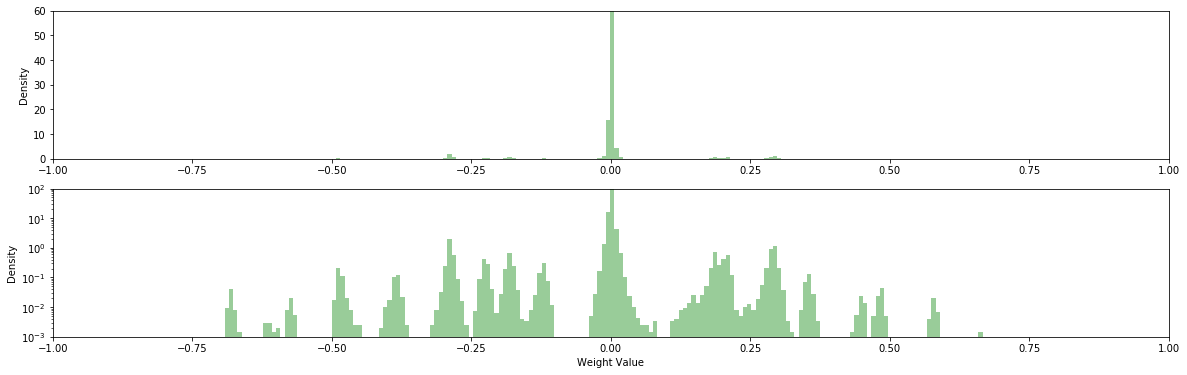

[ 0.         -0.28737342 -0.48841861 -0.68040013 -0.48492336 -0.362344
 -0.18125924 -0.12094716  0.18060756  0.38881642  0.18683232  0.48581079
  0.48245841  0.29048046  0.66387969]
[ 0  0  0 ...  0 13  0]
[ 0.         -0.57325    -0.32726744 -0.12634708 -0.22525859 -0.38391674
 -0.1254594  -0.13289613  0.11506749  0.44903812  0.20699945  0.57868403
  0.11148793  0.28525203  0.35405093]
[ 0  0  0 ... 10  8  0]
[ 0.         -0.61142927 -0.39516911 -0.13593972 -0.47662038 -0.30149642
 -0.32836646 -0.22407629  0.25944394  0.14950445  0.81055033  0.83535135
  0.72840428  0.81210613  0.69856817]
[8 4 2 ... 0 9 0]


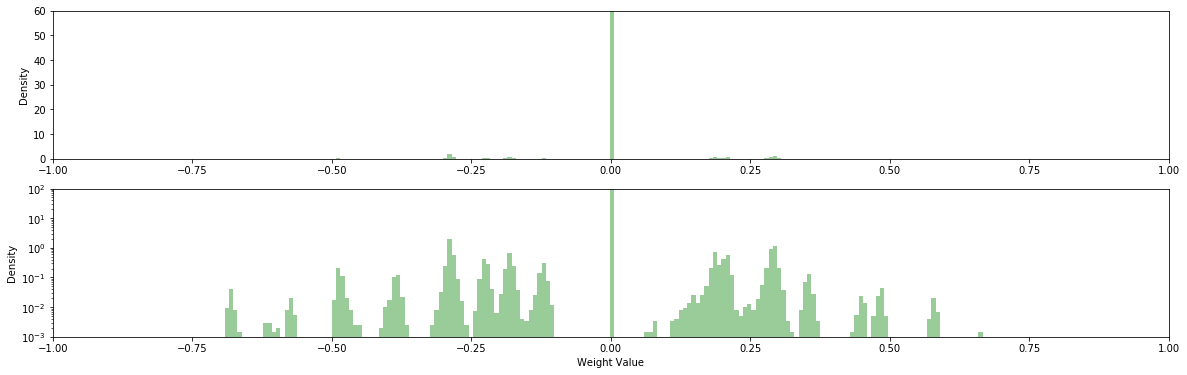

In [7]:
l1_7, g1_7, r1_7, l2_7, g2_7, r2_7, l3_7, g3_7, r3_7, um_7, ur_7 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-7, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

In [ ]:
savedir = './expfiles/'

In [ ]:

model_n = copy.deepcopy(prune_model)
data_size = 'search'
if(data_size == 'search'):
    train_dataset = search_train_data()
if(data_size == 'full'):
    train_dataset = train_data()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
gmp_list = [gmp_1, gmp_2, gmp_3]
means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

for epoch in range(20):
    model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
    #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

    model_n, means = clamp_weights (model_n, means)
    if (trueAfterN(epoch, 10)):
        test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
        print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
        #show_sws_weights(model_n)
    #print (get_sparsity(model_n))
clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
clamped_sp = get_sparsity(model_n)
res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
overall_res += res_str

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


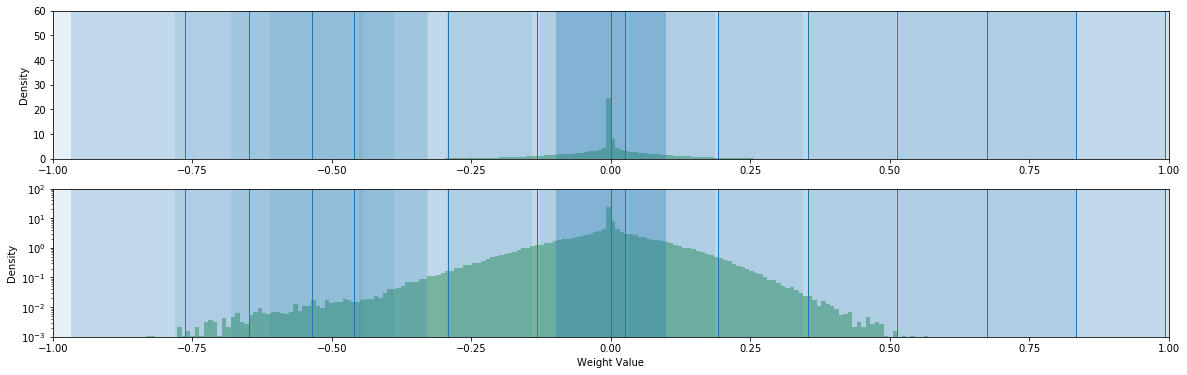

Original: 98.26% - Retrain: 98.28% - Prune: 98.03% - Quantize: 98.07% - Sparsity: 50.79%
Epoch: 50. Loss: 0.00


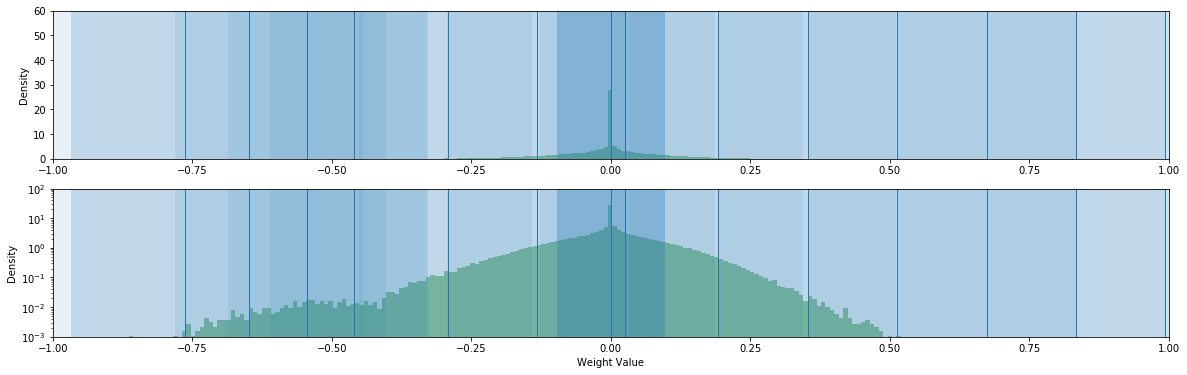

Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
Original: 98.15% - Retrain: 98.12% - Prune: 97.99% - Quantize: 98.03% - Sparsity: 51.51%
Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


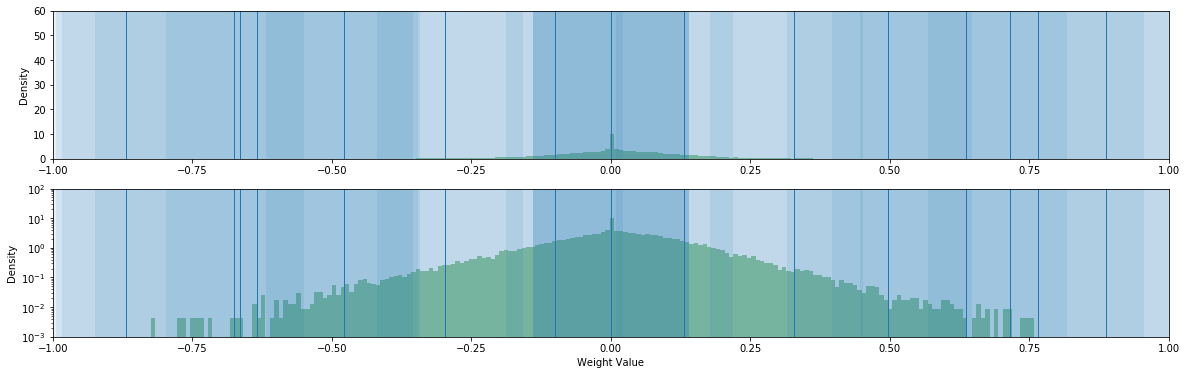

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.09%
Epoch: 50. Loss: 0.00


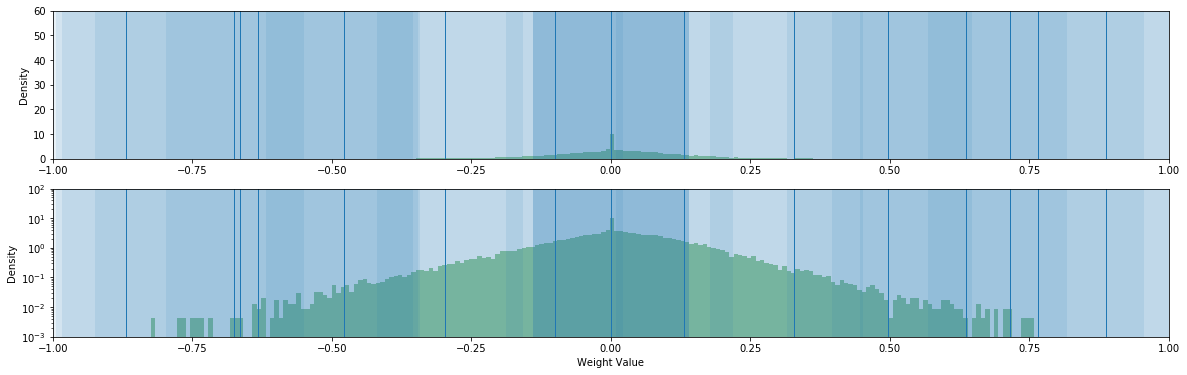

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
Original: 98.15% - Retrain: 98.15% - Prune: 98.16% - Quantize: 98.08% - Sparsity: 42.16%
Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0


In [ ]:
overall_res = ""
for mean in [10, 100, 1000, 10000]:
    for zmean in [10, 100, 1000, 10000]:
        res_str = "Mean: {:.2f} ZMean: {:.2f}\n".format(mean,zmean)
        layer_model_1, gmp_1, res_1 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 1, 'MSEHNA')
        layer_model_2, gmp_2, res_2 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 2, 'MSEHNA')
        layer_model_3, gmp_3, res_3 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-8, 3, 'MSEHNA')
        prune_model = sws_replace(model_archs.LeNet_300_100().cuda(), [sws_prune_l2(layer_model_1, gmp_1), sws_prune_l2(layer_model_2, gmp_2), sws_prune_l2(layer_model_3, gmp_3)])
        test_acc = test_accuracy(val_data_full, val_labels_full, prune_model)
        res_str += "Layer 1 Acc: {:.2f}% - Layer 1 Sp: {:.2f} - Layer 2 Acc: {:.2f}% - Layer 2 Sp: {:.2f} - Layer 3 Acc: {:.2f}% - Layer 3 Sp: {:.2f} - Model Acc: {:.2f} - Model Sp: {:.2f}".format(res_1['prune_val'], res_1['sparsity'], res_2['prune_val'], res_2['sparsity'], res_3['prune_val'], res_3['sparsity'], test_acc[0], get_sparsity(prune_model))

        model_n = copy.deepcopy(prune_model)
        data_size = 'search'
        if(data_size == 'search'):
            train_dataset = search_train_data()
        if(data_size == 'full'):
            train_dataset = train_data()

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_data_full = Variable(test_data(fetch='data')).cuda()
        test_labels_full = Variable(test_data(fetch='labels')).cuda()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
        gmp_list = [gmp_1, gmp_2, gmp_3]
        means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

        for epoch in range(20):
            model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

            test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
            #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

            model_n, means = clamp_weights (model_n, means)
            if (trueAfterN(epoch, 10)):
                test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
                print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
                #show_sws_weights(model_n)
            #print (get_sparsity(model_n))
        clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
        clamped_sp = get_sparsity(model_n)
        res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
        overall_res += res_str

print(overall_res)

In [8]:
r1

NameError: name 'r1' is not defined

In [52]:
#1. Train all 3 layers
#2. Unify model and replace priors
#3. Optimize as usual
def load_layer_retrain_LeNet_300_100(mean, zmean, temp, tau, mixtures, data_size, loss_type = 'MSEHNA', savedir = ''):
    zvar = 10
    var = 2
    model_name = 'LeNet_300_100'
    
    #train 3 layers independently
    #layer_model_1, gmp_1, res_1 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 1, data_size, model_name, loss_type, savedir)
    #layer_model_2, gmp_2, res_2 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 2, data_size, model_name, loss_type, savedir)
    #layer_model_3, gmp_3, res_3 = retrain_layer(mean, var, zmean, zvar, mixtures, temp, tau, 3, data_size, model_name, loss_type, savedir)
    layer_model_1 = loadfile(mean = 5000, zmean = 5000, tau = 1e-7, temp = 1, mixtures = 15, model = "LeNet_300_100FC1", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    layer_model_2 = loadfile(mean = 5000, zmean = 5000, tau = 1e-5, temp = 1, mixtures = 15, model = "LeNet_300_100FC2", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    layer_model_3 = loadfile(mean = 5000, zmean = 5000, tau = 1e-4, temp = temp, mixtures = 15, model = "LeNet_300_100FC3", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "model")
    gmp_1 = loadfile(mean = 5000, zmean = 5000, tau = 1e-7, temp = 1, mixtures = 15, model = "LeNet_300_100FC1", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    gmp_2 = loadfile(mean = 5000, zmean = 5000, tau = 1e-5, temp = 1, mixtures = 15, model = "LeNet_300_100FC2", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    gmp_3 = loadfile(mean = 5000, zmean = 5000, tau = 1e-4, temp = temp, mixtures = 15, model = "LeNet_300_100FC3", data_size = 'search', scaling = False, model_save_dir = "./expfiles", file = "gmp")
    
    #transfer GMP to new unified model architecture
    unified_model = sws_replace(model_archs.LeNet_300_100().cuda(), [layer_model_1.state_dict(), layer_model_2.state_dict(), layer_model_3.state_dict()])
    gmp_u1 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc1.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_1.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u2 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc2.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_2.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u3 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc3.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_3.means.clone().data.cpu().numpy(), scaling = False)

    #load datasets
    data_size = 'search'
    if(data_size == 'search'):
        train_dataset = search_train_data()
        val_data_full = Variable(test_data(fetch='data')).cuda()
        val_labels_full = Variable(test_data(fetch='labels')).cuda()
        un_val_acc = test_accuracy(val_data_full, val_labels_full, unified_model)[0]
    if(data_size == 'full'):
        train_dataset = train_data()

    loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    
    
    #unified accuracy
    unify_res = plot_data(unified_model, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    unify_res.data_epoch(0, unified_model)
    
    #prune-stats before retraining
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    unify_res.data_prune(pruned_model)
    preprune = copy.deepcopy(unify_res.prune_acc)
    presparsity = unify_res.sparsity
    
    #init optimizers
    loss_type = 'MSESNT'
    opt_1 = torch.optim.Adam([
            {'params': unified_model.fc1.parameters(), 'lr': 1e-4},
            {'params': [gmp_u1.means], 'lr': 3e-4},
            {'params': [gmp_u1.gammas, gmp_u1.rhos], 'lr': 3e-3}])
    opt_2 = torch.optim.Adam([
            {'params': unified_model.fc2.parameters(), 'lr': 1e-4},
            {'params': [gmp_u2.means], 'lr': 3e-4},
            {'params': [gmp_u2.gammas, gmp_u2.rhos], 'lr': 3e-3}])
    opt_3 = torch.optim.Adam([
            {'params': unified_model.fc3.parameters(), 'lr': 1e-4},
            {'params': [gmp_u3.means], 'lr': 3e-4},
            {'params': [gmp_u3.gammas, gmp_u3.rhos], 'lr': 3e-3}])

    #align and retrain
    show_sws_weights(unified_model)
    retraining_epochs=30
    for epoch in range(retraining_epochs):
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u1, opt_1, loader, 1e-7, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u2, opt_2, loader, 1e-5, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u3, opt_3, loader, 1e-4, 1, loss_type)
        #test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
        #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
        #model_n, means = clamp_weights (model_n, means)
        unify_res.data_epoch(epoch+1, unified_model)
        
        if (trueAfterN(epoch, 10)):
            print ("Epoch: {}, Test Acc: {:.2f}".format(epoch+1, unify_res.test_accuracy[-1]))
    show_sws_weights(unified_model)

    #prune model
    l1_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune_l2(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    show_sws_weights(pruned_model)
    unify_res.data_prune(pruned_model)
    
    ures = unify_res.gen_dict()
    cm = compressed_model(pruned_model.state_dict(), [gmp_u1, gmp_u2, gmp_u3])
    ures['cm'] = cm.get_cr_list()
    ures['pre-sp'] = presparsity
    ures['pre-prune_acc'] = preprune

    show_sws_weights(pruned_model)
        
    ###SAVE MODEL, GMP, Res
    if (savedir != ""):
        #exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}".format(unified_model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), data_size)
        exp_name = "min_error2"
        torch.save(unified_model, savedir + '/mnist_retrain_layer_umodel_{}.m'.format(exp_name))
        with open(savedir + '/mnist_retrain_layer_u1gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u1, f)
        with open(savedir + '/mnist_retrain_layer_u2gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u2, f)
        with open(savedir + '/mnist_retrain_layer_u3gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u3, f)
        with open(savedir + '/mnist_retrain_layer_ures_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(ures, f)
    
    return layer_model_1, gmp_1, layer_model_2, gmp_2, layer_model_3, gmp_3, unified_model, ures

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0


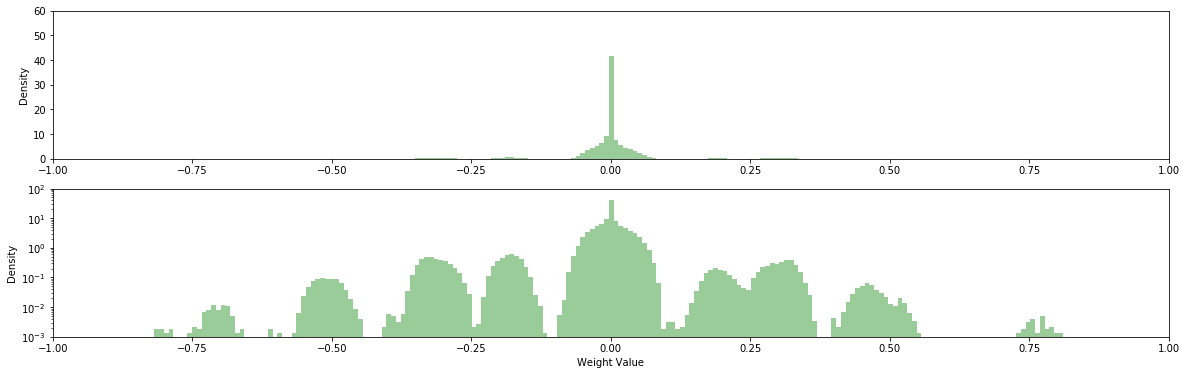

RuntimeError: input and target have different number of elements: input[128 x 10] has 1280 elements, while target[128] has 128 elements at /opt/conda/conda-bld/pytorch_1518241554738/work/torch/lib/THCUNN/generic/MSECriterion.cu:15

> /anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/functional.py(1248)_pointwise_loss()
   1246         return torch.mean(d) if size_average else torch.sum(d)
   1247     else:
-> 1248         return lambd_optimized(input, target, size_average, reduce)
   1249 
   1250 

ipdb> exit


In [53]:
l1_4, g1_4, l2_4, g2_4, l3_4, g3_4, um_4, ur_4 = load_layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-5, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

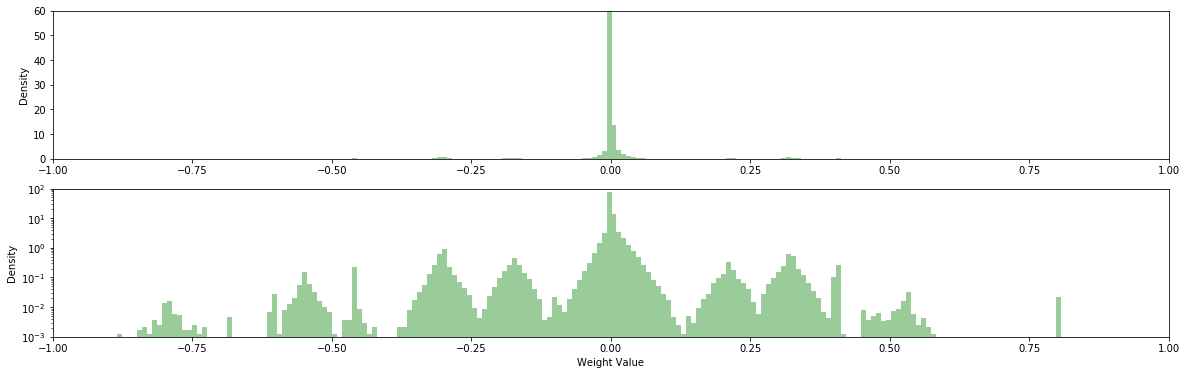

In [51]:
show_sws_weights(um_4)

In [22]:
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")
layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)

Original: 98.26% - Retrain: 97.24% - Prune: 95.52% - Quantize: 94.95% - Sparsity: 97.40%


(97.24, 95.52, 94.95, 97.40382165605097)